# Final ROC Plotter

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
import random
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import awkward as ak
import hist
from hist import Hist, axis

   runID  eventID                                              times  \
0   6940     3177  [-3632.0, -3622.0, -3612.0, -3602.0, -3592.0, ...   
1   6940     7831  [-3642.0, -3632.0, -3622.0, -3612.0, -3602.0, ...   
2   6940     9904  [-1312.0, -1302.0, -1292.0, -1282.0, -1272.0, ...   
3   6940    15136  [-823.0, -813.0, -803.0, -793.0, -783.0, -773....   
4   6940    16478  [-813.0, -803.0, -793.0, -783.0, -773.0, -763....   

                                             samples  length          area  \
0  [0.00036996949347667396, -0.000351915950886905...    1101   9605.476562   
1  [0.0009631378925405443, 0.0009631378925405443,...     932   8454.574219   
2  [-0.003676149994134903, -0.004674938507378101,...     525  10806.775391   
3  [-0.004523166920989752, 0.0026921471580863, -0...     640  11460.135742   
4  [-0.009625015780329704, -0.004182628821581602,...     656  11764.575195   

   max_pulse_height    ext_elec          x          y          r  S2_width  \
0          2.721810 

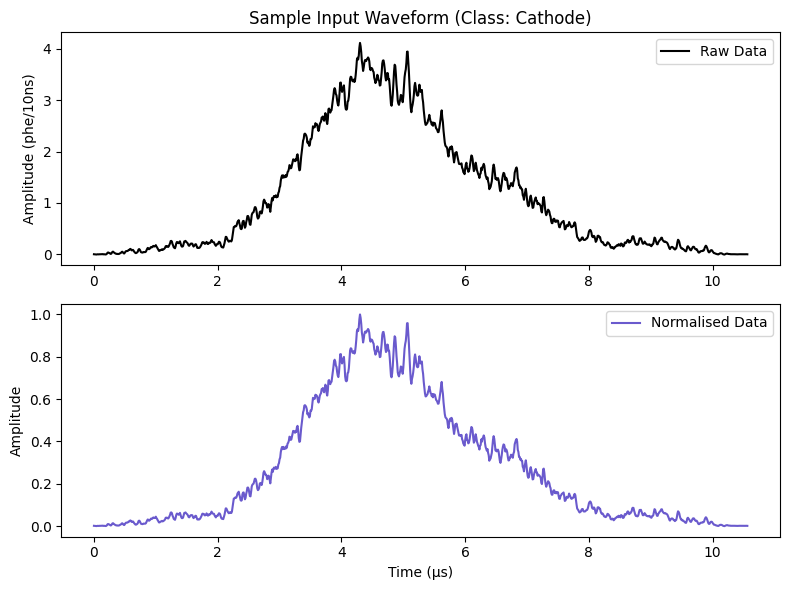

(7782, 2828)
(7782, 2828)


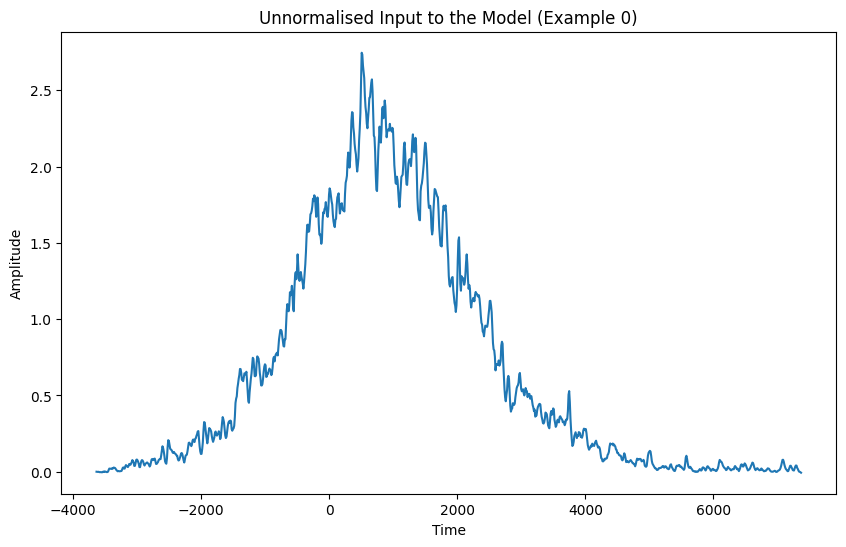

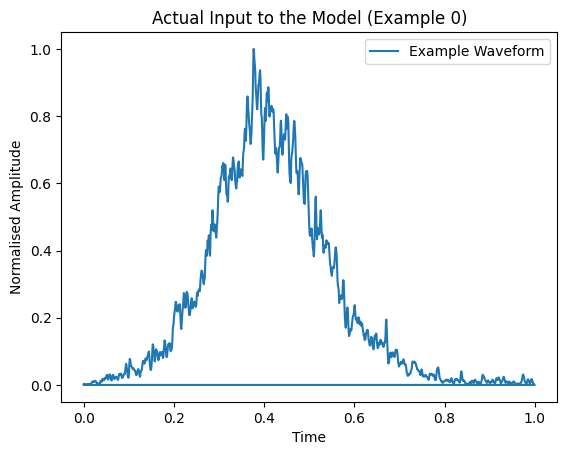

305.75293803418805


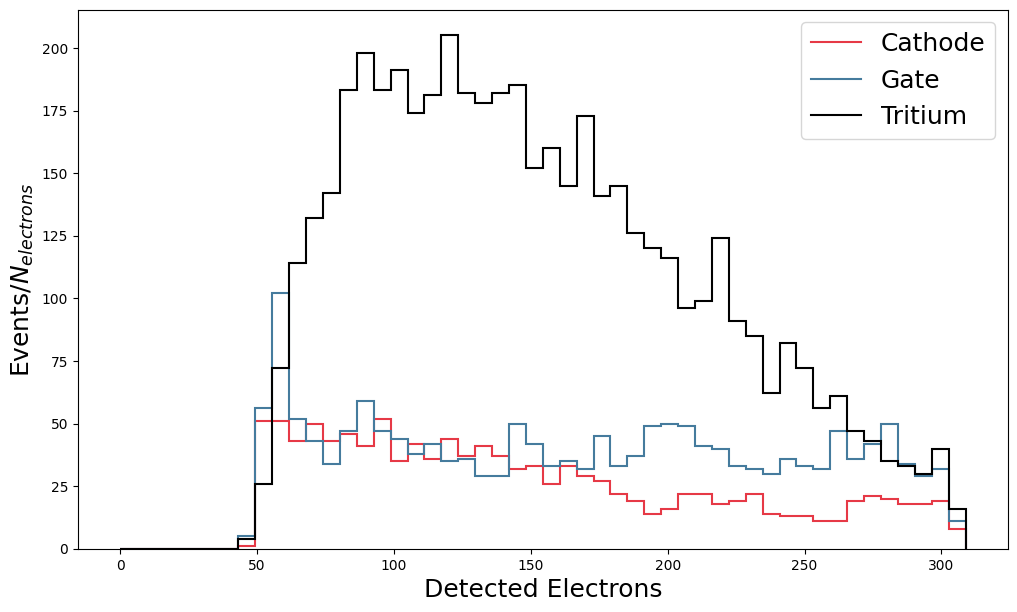

[  0.   0.   0.   0.   0.   0.   0.   4.  26.  72. 114. 132. 142. 183.
 198. 183. 191. 174. 181. 205. 182. 178. 182. 185. 152. 160. 145. 173.
 141. 145. 126. 120. 116.  96.  99. 124.  91.  85.  62.  82.  72.  56.
  61.  47.  43.  35.  33.  30.  40.  16.]
[  0.   0.   0.   0.   0.   0.   0.   5.  56. 102.  52.  43.  34.  47.
  59.  47.  44.  38.  42.  35.  36.  29.  29.  50.  42.  33.  35.  32.
  45.  33.  37.  49.  50.  49.  41.  40.  33.  32.  30.  36.  33.  32.
  47.  36.  42.  50.  34.  29.  32.  11.]
[ 0.  0.  0.  0.  0.  0.  0.  1. 51. 51. 43. 50. 43. 46. 41. 52. 35. 42.
 36. 44. 37. 41. 37. 32. 33. 26. 33. 29. 27. 22. 19. 14. 16. 22. 22. 18.
 19. 22. 14. 13. 13. 11. 11. 19. 21. 20. 18. 18. 19.  8.]
302.6342580662393
1189.0
0.05233506589633088
0.03598035780372748
0.02616753294816544
MAX areas: tritum,gate, cathode, overall dataset (17881.375, 17847.5546875, 17886.546875, 17886.546875)
13.425698081402867
37.559123858611976
10.27318981302282
[ 0.          0.          0.          0. 

/var/folders/8d/lxs1vkm92sx23cl8twt_cnt00000gn/T/ipykernel_12728/1340835184.py:276: RuntimeWarning: divide by zero encountered in double_scalars
  gate_weights.append(1 / (gate_counts[datapoint] / gate_counts.sum()))
/var/folders/8d/lxs1vkm92sx23cl8twt_cnt00000gn/T/ipykernel_12728/1340835184.py:282: RuntimeWarning: divide by zero encountered in double_scalars
  tritium_weights.append(1 / (tritium_counts[datapoint] / tritium_counts.sum()))
/var/folders/8d/lxs1vkm92sx23cl8twt_cnt00000gn/T/ipykernel_12728/1340835184.py:288: RuntimeWarning: divide by zero encountered in double_scalars
  cathode_weights.append(1 / (cathode_counts[datapoint] / cathode_counts.sum()) if datapoint < (len(cathode_counts)-1) else 0)
/var/folders/8d/lxs1vkm92sx23cl8twt_cnt00000gn/T/ipykernel_12728/1340835184.py:299: RuntimeWarning: invalid value encountered in multiply
  gate_errors = np.sqrt(gate_counts) * gate_weights /70 # * (average_counts / gate_counts.sum())
/var/folders/8d/lxs1vkm92sx23cl8twt_cnt00000gn/T/i

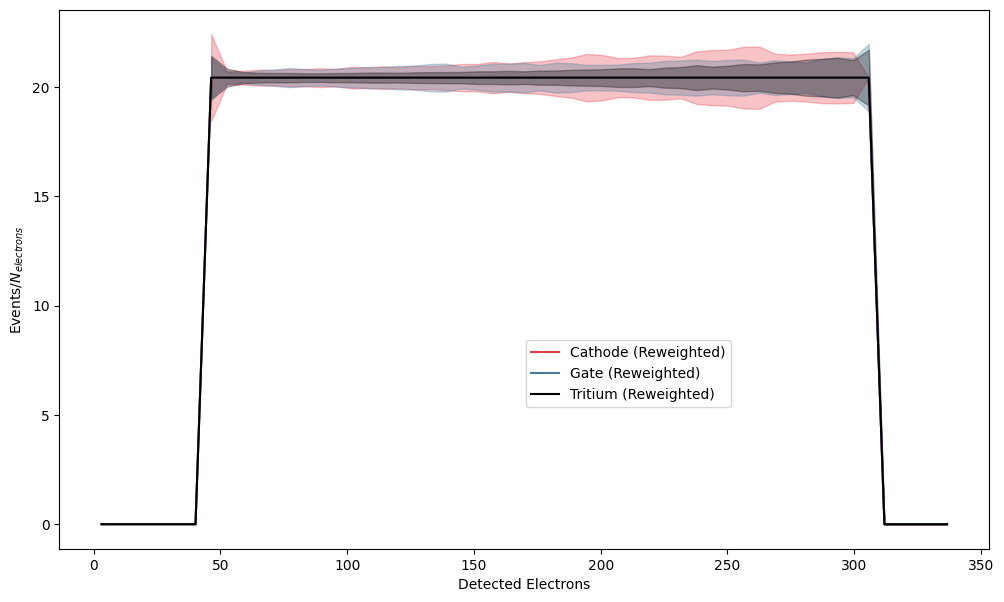

these are da 50
1711.0
4882.0
1189.0
7782
<class 'numpy.ndarray'>
7782
4882
[8.04, 0.179, 2.1, 2.1, 2.1, 2.1, 2.1, ..., 12.1, 12.1, 12.1, 12.1, 12.1, 12.1]
7782
Length of X_train: 5836
Length of y_train: 5836
Length of weights_train: 5836
Shape of weights_train: (5836,)
Shape of X_train: (5836, 2828)
Shape of y_train: (5836,)
(1946, 2828, 1)


In [2]:
DATA_path = '/Users/laith_mohajer/Documents/GitHub/MSCIProject/LZ Datasets/padded_waveforms.parquet'
df = pd.read_parquet(DATA_path)
print(df.head())
arr = ak.from_parquet(DATA_path) #Awkward DataFrame also created for future use
print(arr.fields) #analogous to df.columns.tolist()


def normalise_array(arr):
    # Normalise each sub-array individually and return as an awkward array
    return ak.Array([
        (sub_array - np.min(sub_array)) / (np.max(sub_array) - np.min(sub_array)) if np.max(sub_array) != np.min(sub_array) else sub_array
        for sub_array in ak.to_list(arr)
    ])

def remove_array_offset(arr):
    # Normalise each sub-array individually and return as an awkward array
    return ak.Array([
        (sub_array - np.min(sub_array)) if np.max(sub_array) != np.min(sub_array) else sub_array
        for sub_array in ak.to_list(arr)
    ])

# Apply normalisation to each column
normalised_times = normalise_array(arr['times'])
normalised_samples = normalise_array(arr['samples'])
normalised_areas = normalise_array(arr['area'])

unnormalised_times = remove_array_offset(arr['times']) # Unnormalised times but shifted to start at zero (offset remove)

print(f"Lengths of first few subarrays in normalised_times: {ak.num(normalised_times, axis=1)[:10]}")
print(f"Example subarray from normalised_times: {normalised_times[0]}")
print(f"Example subarray from unnormalised_times: {unnormalised_times[3654]}")


# Print minimum and length for testing
# print(f"Minimum values of sub-arrays: {[sub_array.min() for sub_array in padded_times]}")
# print(f"Length of sub-array 200: {len(padded_times[200])}")

# Lets pad the time data first using Awkward jargon

# first, an initial check to see if data row entry (training example) has an associated label. filtering for both NaNs and None values.
missing_label_count = len(arr[(arr['label'] != 0) & (arr['label'] != 1) & (arr['label'] != 2)])
print("Number of rows with unexpected or missing labels:", missing_label_count)

nan_areas = len(arr[ak.is_none(arr['area'])])
print("Number of NaN values in area column:", nan_areas)
# print(type(electron_size))

# Convert columns to numpy arrays, pad, and convert back to Awkward Arrays
def pad_to_max_length(array, max_length):
    return ak.Array(
        np.array(
            [np.pad(sub_array, (0, max_length - len(sub_array)), mode='constant', constant_values=0) for sub_array in ak.to_list(array)]
        )
    )

print(len(arr['times']))
print(f"Length Before Padding: {len(arr['times'][0])}")
print("Structure of 'times':", ak.type(arr['times']))

times_lengths = ak.num(arr['times'], axis=1)
max_time_length = ak.max(times_lengths) # returns length of longest time series in dataset
max_time_length_index = ak.argmax(times_lengths)

print(f'Results are: \n Max. Length = {max_time_length} \n Max. Length Index = {max_time_length_index}')

# Apply padding
padded_times = np.array(pad_to_max_length(normalised_times, max_time_length))
unnormalised_padded_times = np.array(pad_to_max_length(unnormalised_times, max_time_length))

sampling_interval_us = 0.01 # interval between consecutive samples in microseconds
time_us = [np.arange(len(wave)) * sampling_interval_us for wave in arr["times"]]
print(time_us[1036]) #TEST: the last element in this row should equal 18.3 µs

print(f"Length After Padding: {len(padded_times[0])}")
print(f"Length After Padding: {len(unnormalised_padded_times[3743])}")
print(len(arr['samples']))
print(f"Length Before Padding: {len(arr['samples'][0])}")
print("Structure of 'times':", ak.type(arr['samples']))

samples_lengths = ak.num(arr['times'], axis=1)
max_samples_length = ak.max(samples_lengths)
max_samples_length_index = ak.argmax(samples_lengths)

print(f'Results are: \n Max. Length = {max_samples_length} \n Max. Length Index = {max_samples_length_index}')

# Apply padding
padded_samples = np.array(pad_to_max_length(normalised_samples, max_samples_length))

print(f"Length After Padding: {len(padded_samples[0])}")
# print(padded_samples[0][-200:])
fig, axs = plt.subplots(2, 1, figsize=(8, 6))  # axs is an array of Axes

sample_idx = 32

event_types = {
    "Cathode": 0,
    "Gate": 1,
    "Tritium": 2
}
class_label = arr['label'][sample_idx]
# Create a reverse mapping to find key from value
# This creates a new dictionary with values as keys and keys as values
reverse_event_types = {v: k for k, v in event_types.items()}

# Now use the reverse mapping to get the event name
event_name = reverse_event_types[class_label]

print(event_types.items())
# Plot the first dataset in the first subplot
axs[0].plot(time_us[sample_idx], arr['samples'][sample_idx], label='Raw Data', color='black')
axs[0].set_title(f"Sample Input Waveform (Class: {event_name})")
axs[0].set_ylabel("Amplitude (phe/10ns)")
axs[0].legend()

# Plot the second dataset in the first subplot
axs[1].plot(time_us[sample_idx], normalised_samples[sample_idx], label='Normalised Data', color='slateblue')
#axs[1].set_title("Normalised Data")
axs[1].set_ylabel("Amplitude")
axs[1].legend()

# # Plot the third dataset in the second subplot
# axs[2].plot(padded_times[32], padded_samples[32], label='Normalised + Padded Data', color='deeppink')
# axs[2].set_title("Normalised + Padded Data")
# axs[2].set_ylabel("Normalised Amplitude")
# axs[2].legend()

# Add overall labels
plt.xlabel("Time (µs)")

# Adjust spacing between subplots for readability
plt.tight_layout()

# Show the plot
#plt.savefig('/Users/laith_mohajer/Documents/GitHub/MSCIProject/Figures/errorsinpaddingandnormalising.png')
#plt.savefig('/Users/laith_mohajer/Documents/GitHub/MSCIProject/Figures/raw+normalisedwaveform.png', dpi=1800)
plt.show()
import pandas as pd
from sklearn.model_selection import train_test_split
# Define padding length
padding_length = 500

# X = arr[['times', 'samples']] #creates a mini array from mother array with only 'times' and 'samples' columns
#print(X)
y = np.array(arr['label']) # labelled as 0,1 and 2 corresponding to cathode, gate and tritium respectively. this is the true output data#

# Add zero-padding on each side of the data (only along the time dimension for 2D data) Then reshape X_train_padded and X_test_padded to 3D
normalised_times_padded = np.pad(padded_times, ((0, 0), (padding_length, padding_length)), mode='constant', constant_values=0)
unnormalised_times_padded = np.pad(unnormalised_padded_times, ((0, 0), (padding_length, padding_length)), mode='constant', constant_values=0)
normalised_samples_padded = np.pad(padded_samples, ((0, 0), (padding_length, padding_length)), mode='constant', constant_values=0)
X = normalised_samples_padded
print(normalised_times_padded.shape)
print(X.shape)

time_steps = normalised_times_padded.shape[1]
example_index = 0
example_row = X[example_index]

# Split the row into time and samples
example_time = normalised_times_padded[example_index][500:-500]  # The time data of sample index {example_index}
example_samples = example_row[500:-500]  # The sample data of sample index {example_index}

plt.figure(figsize=(10, 6))
plt.plot(arr['times'][0], arr['samples'][0])
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title(f"Unnormalised Input to the Model (Example {example_index})")

plt.show()
plt.plot(example_time, example_samples, label="Example Waveform")
plt.xlabel("Time")
plt.ylabel("Normalised Amplitude")
plt.title(f"Actual Input to the Model (Example {example_index})")
plt.legend()
# plt.grid(True)
plt.show()
areas = arr['area']
max_area = max(areas)

# Electron size (conversion factor)
electron_size = 58.5
print(max(areas) / electron_size)

# Set the number of bins to 50 (x2 wider than 100 bins)
bins = 50
# Calculate the upper range (with a 1% buffer) in units of detected electrons.
bin_range = max_area / electron_size * 1.01
# Compute the bin width in number of detected electrons
bin_width = bin_range / bins

# Create a histogram for gate, tritium and cathode data.
gate_events = arr[(arr['label'] == 1)].area / electron_size
tritium_events = arr[(arr['label'] == 2)].area / electron_size
cathode_events = arr[(arr['label'] == 0)].area / electron_size

gate_hist = Hist(axis.Regular(bins, 0, bin_range))
gate_hist.fill(gate_events)

tritium_hist = Hist(axis.Regular(bins, 0, bin_range))
tritium_hist.fill(tritium_events)

cathode_hist = Hist(axis.Regular(bins, 0, bin_range))
cathode_hist.fill(cathode_events)

# Retrieve histogram bins and values
tritium_bins = tritium_hist.axes[0].edges
tritium_values = tritium_hist.values()

gate_bins = gate_hist.axes[0].edges
gate_values = gate_hist.values()

cathode_bins = cathode_hist.axes[0].edges
cathode_values = cathode_hist.values()

# Create a figure and axis
plt.figure(figsize=(12, 7))

# Plot each histogram with the specified colors and line options:
plt.stairs(cathode_values, cathode_bins, fill=False, color='#E63946', linewidth=1.5, label='Cathode')
plt.stairs(gate_values, gate_bins, fill=False, color='#457B9D', linewidth=1.5, label='Gate')
plt.stairs(tritium_values, tritium_bins, fill=False, color='black', linewidth=1.5, label='Tritium')

# Add labels and title
plt.xlabel('Detected Electrons', fontsize=18)
plt.ylabel(f"Events/$N_{{electrons}}$", fontsize=18)
plt.legend(fontsize=18)

# Save and show the figure
#plt.savefig('/Users/laith_mohajer/Documents/GitHub/MSCIProject/Figures/fugazed_HE_area_histogram.png', dpi=1800)
plt.show()

# Optional: print histograms' view for debugging
print(tritium_hist.view())
print(gate_hist.view())
print(cathode_hist.view())

bin_edges = gate_hist.axes[0].edges  # Get bin edges from one of the histograms
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers
print(bin_edges[-2])

# Retrieve and adjust counts for each histogram
gate_counts = gate_hist.view() / bin_centers
tritium_counts = tritium_hist.view() / bin_centers
cathode_counts = cathode_hist.view() / bin_centers

print(cathode_hist.view().sum())
print(tritium_counts[-1])
print(gate_counts[-1])
print(cathode_counts[-1])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7), sharex=True, sharey=True)  #Initialise new fig object to plot weighted, flat spectrum
fig.subplots_adjust(hspace=0.0)

areas = arr['area']

max_tritium_area = max(areas[arr.label == 2])
max_gate_area = max(areas[arr.label == 1])
max_cathode_area = max(areas[arr.label == 0])
max_area = max(areas)
print(f'MAX areas: tritum,gate, cathode, overall dataset {max_tritium_area, max_gate_area, max_cathode_area, max_area}')

# Calculate the target flat spectrum as the average of the three histograms
gate_data = gate_hist.view(flow=False)
tritium_data = tritium_hist.view(flow=False) 
cathode_data = cathode_hist.view(flow=False) 

print(gate_counts.sum()) # total area under the histogram (integral of histogram)
print(tritium_counts.sum()) # total area under the histogram (integral of histogram)
print(cathode_counts.sum()) # total area under the histogram (integral of histogram)

average_counts = np.mean([gate_counts.sum(), tritium_counts.sum(),cathode_counts.sum()]) # average integral (area) of each histgoram to be used as reweighting benchmark

gate_weights = []
gate_reweighted  = []
for datapoint in range(len(gate_counts)):
    gate_reweighted.append(gate_counts[datapoint] * (1 / (gate_counts[datapoint] / gate_counts.sum())) if gate_counts[datapoint] != 0 else 0)
    gate_weights.append(1 / (gate_counts[datapoint] / gate_counts.sum()))

tritium_weights = []
tritium_reweighted = []
for datapoint in range(len(tritium_counts)):
    tritium_reweighted.append(tritium_counts[datapoint] * (1 / (tritium_counts[datapoint] / tritium_counts.sum())) if tritium_counts[datapoint] != 0 else 0)
    tritium_weights.append(1 / (tritium_counts[datapoint] / tritium_counts.sum()))

cathode_weights = []
cathode_reweighted = []
for datapoint in range(len(cathode_counts)):
    cathode_reweighted.append(cathode_counts[datapoint] * (1 / (cathode_counts[datapoint] / cathode_counts.sum())) if cathode_counts[datapoint] != 0 else 0)
    cathode_weights.append(1 / (cathode_counts[datapoint] / cathode_counts.sum()) if datapoint < (len(cathode_counts)-1) else 0)

gate_reweighted = np.array(gate_reweighted)
tritium_reweighted = np.array(tritium_reweighted)

#tritium_reweighted[-1] = 37.92238004
cathode_reweighted = np.array(cathode_reweighted)

print(gate_reweighted)

#errorbars
gate_errors = np.sqrt(gate_counts) * gate_weights /70 # * (average_counts / gate_counts.sum())
tritium_errors = np.sqrt(tritium_counts) * tritium_weights /70 # * (average_counts / tritium_counts.sum())
cathode_errors = np.sqrt(cathode_counts) * cathode_weights/70 # * (average_counts / cathode_counts.sum())

# PADDING: Append zeros to make the histogram look like a "tophat"
tophat_padding = 5  # Number of zeros to add
gate_reweighted = np.append(gate_reweighted, [0] * tophat_padding)
tritium_reweighted = np.append(tritium_reweighted, [0] * tophat_padding)
cathode_reweighted = np.append(cathode_reweighted, [0] * tophat_padding)

gate_errors = np.append(gate_errors, [0] * tophat_padding)
tritium_errors = np.append(tritium_errors, [0] * tophat_padding)
cathode_errors = np.append(cathode_errors, [0] * tophat_padding)

# Extend bin_centers by adding extra bins to match the "tophat" shape
bin_step = bin_centers[1] - bin_centers[0]  # Calculate the step size between bins
extended_bin_centers = np.append(bin_centers, bin_centers[-1] + bin_step * np.arange(1, tophat_padding + 1))


# Apply reweighting by multiplying the original data by the weights

# Cathode
ax.plot(extended_bin_centers, cathode_reweighted * (average_counts / cathode_counts.sum()), color='#E63946', label='Cathode (Reweighted)')
ax.fill_between(
    extended_bin_centers, 
    (cathode_reweighted - cathode_errors) * (average_counts / cathode_counts.sum()), 
    (cathode_reweighted + cathode_errors) * (average_counts / cathode_counts.sum()), 
    color='#E63946', alpha=0.3
)

# Gate
ax.plot(extended_bin_centers, gate_reweighted * (average_counts / gate_counts.sum()), color='#457B9D', label='Gate (Reweighted)')
ax.fill_between(
    extended_bin_centers, 
    (gate_reweighted - gate_errors) * (average_counts / gate_counts.sum()), 
    (gate_reweighted + gate_errors) * (average_counts / gate_counts.sum()), 
    color='#457B9D', alpha=0.3
)

# Tritium
ax.plot(extended_bin_centers, tritium_reweighted * (average_counts / tritium_counts.sum()), color='black', label='Tritium (Reweighted)')
ax.fill_between(
    extended_bin_centers, 
    (tritium_reweighted - tritium_errors) * (average_counts / tritium_counts.sum()), 
    (tritium_reweighted + tritium_errors) * (average_counts / tritium_counts.sum()), 
    color='black', alpha=0.3
)

ax.set(xlabel='Detected Electrons',ylabel='Events/$N_{electrons}$')
#ax.set_yscale('log')
ax.legend(bbox_to_anchor=(0.73,0.4),loc='upper right',frameon=True) 
#plt.savefig('/Users/laith_mohajer/Documents/GitHub/MSCIProject/Figures/HE_weighted_pulse_spectrum.png', dpi=1800)
plt.show()

gate_weights = np.array(gate_weights)
gate_weights = np.where(np.isinf(gate_weights), 0, gate_weights) # check if values are defined (finite), 0 if not.

tritium_weights = np.array(tritium_weights)
tritium_weights = np.where(np.isinf(tritium_weights), 0, tritium_weights)

cathode_weights = np.array(cathode_weights)
cathode_weights = np.where(np.isinf(cathode_weights), 0, cathode_weights)

#gate_weights = gate_weights.ravel() # gate_weights was found to be a 2D array with only 1 row which prohibited proper indexing. ravel() flattens to 1D ndarray.
print(f'these are da {gate_weights.size}')

print(gate_data.sum())
print(tritium_data.sum())
print(cathode_data.sum())

def subdataset_total_weights(dataset_weights, n_data_per_bin):
    n_data_per_bin = np.array(n_data_per_bin, dtype=int) #creates a copy of array that is an ndarray with every element being an integer
    weight_list = []
    for i in range(bins):
        weight_list.extend([dataset_weights[i]] * n_data_per_bin[i])
    return np.array(weight_list)

g_weights = subdataset_total_weights(gate_weights, gate_data)
t_weights = subdataset_total_weights(tritium_weights, tritium_data)
c_weights = subdataset_total_weights(cathode_weights, cathode_data)

print(g_weights.size + t_weights.size + c_weights.size)
print(type(g_weights))
print(len(arr))

weight_column_4_mainarray = np.zeros(len(arr))
# print(len(arr['weights'])) #check to ensure its same length as number of training examples

# Now we need to create an iterative loop that finds a cathode, gate or tritium training example and populates its assoicated weight with the correct weight parameter from its respective weight array

gate_event_counter = 0
cathode_event_counter = 0
tritium_event_counter = 0

print(len(t_weights))

for i in range(len(arr)):
    if arr['label'][i] == 0: # Cathode
        # print(g_weights[i])
        weight_column_4_mainarray[i] = c_weights[gate_event_counter]
        gate_event_counter += 1
    elif arr['label'][i] == 1: # Gate
        weight_column_4_mainarray[i] = g_weights[cathode_event_counter]
        cathode_event_counter += 1
    else: # Tritium (as we have already verified there are no None or NaN entries)
        weight_column_4_mainarray[i] = t_weights[tritium_event_counter]
        tritium_event_counter += 1

arr['weights'] = weight_column_4_mainarray # a new weight column has been initialised!

num_events = len(arr['weights'])
total_weight = ak.sum(arr['weights'])
mean_weight = total_weight / num_events
weights_mean_one = arr['weights'] / mean_weight # rescale all weights to have a mean of 1.
arr = ak.with_field(arr, weights_mean_one, 'weights_normalised')
print(arr['weights_normalised'])

from tensorflow.keras.callbacks import EarlyStopping

weights_np = ak.to_numpy(arr['weights'])
normalised_weights_np = ak.to_numpy(arr['weights_normalised'])
print(len(weights_np))
# An issue arises here initially as arr['weights'] is an awkward array. Keras only recognises and deals with a NumPy array therefore conversion is neccessary
# Another issue also arises in that the test and train data do not have asscoated weights as the weights column was initialised after the split was made
# 'arr' is the original dataset
normalised_area = ak.to_numpy(arr['area'] / electron_size)  # converting 'area' to detected electrons by dividing by 58.5

labels = arr['label']

radii = ak.to_numpy(arr['r'])

# TO ALTER BETWEEN WEIGHTS AND NORMLAISED WEIGHTS> CHANGE WEIGHTS_NP VARIABLE ACCORDINGLY> DEFAULT: NORMALISED WEIGHTS
X_train, X_test, y_train, y_test, area_train, area_test, weights_train, weights_test, \
normalised_times_train, normalised_times_test, times_us_train, times_us_test, \
normalised_samples_train, normalised_samples_test, r_train, r_test = train_test_split(
    X, labels, normalised_area, normalised_weights_np, normalised_times, time_us, normalised_samples, radii, 
    test_size=0.25, random_state=42
)

print("Length of X_train:", len(X_train))
print("Length of y_train:", len(y_train))
print("Length of weights_train:", len(weights_train))
print("Shape of weights_train:", weights_train.shape)
print("Shape of X_train:", X_train.shape)

y_train = np.array(y_train) # this is neccessary as train_test_split often returns lists instead of ndarrays but Keras.model.fit requires the functionality of ndarrays
y_test = np.array(y_test)
print("Shape of y_train:", y_train.shape)

y_test_np = ak.to_numpy(y_test)
area_test_np = ak.to_numpy(area_test)

X_train_padded = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) # adding a channels dimension (greyscale of 1) to enable seamless input into CNN
X_test_padded = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(X_test_padded.shape)

Loading data...
Data prepared. Training samples: 5836, Test samples: 1946
Building and training models...
Training CNN model...
Epoch 1/15
15/15 [==============================] - 111s 7s/step - loss: 0.5994 - accuracy: 0.7894 - val_loss: 0.4220 - val_accuracy: 0.8519 - lr: 5.7620e-04
Epoch 2/15
15/15 [==============================] - 109s 7s/step - loss: 0.4400 - accuracy: 0.8410 - val_loss: 0.3675 - val_accuracy: 0.8587 - lr: 5.7620e-04
Epoch 3/15
15/15 [==============================] - 105s 7s/step - loss: 0.3825 - accuracy: 0.8554 - val_loss: 0.3170 - val_accuracy: 0.8810 - lr: 5.7620e-04
Epoch 4/15
15/15 [==============================] - 101s 7s/step - loss: 0.3553 - accuracy: 0.8702 - val_loss: 0.3016 - val_accuracy: 0.8818 - lr: 5.7620e-04
Epoch 5/15
15/15 [==============================] - 99s 7s/step - loss: 0.3370 - accuracy: 0.8740 - val_loss: 0.3178 - val_accuracy: 0.8853 - lr: 5.7620e-04
Epoch 6/15
15/15 [==============================] - 103s 7s/step - loss: 0.3259 - a

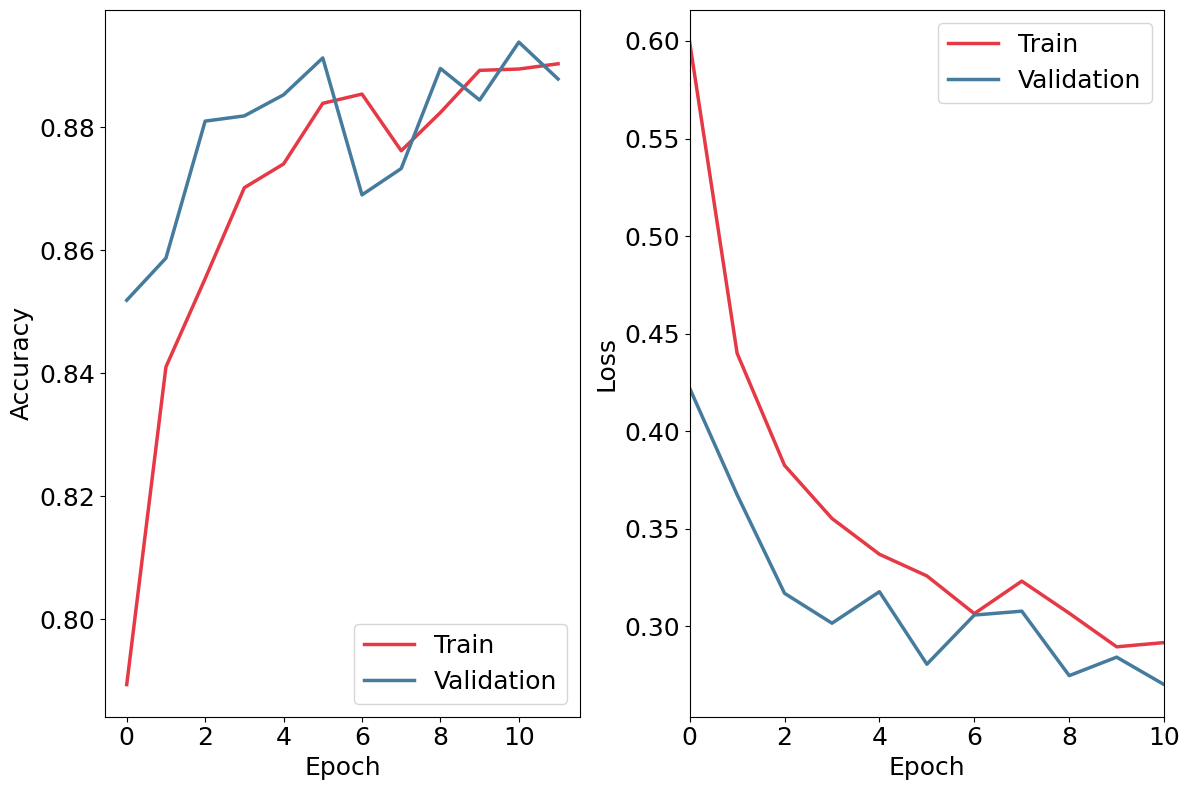

Training BDT model...
Training RF model...
All models trained.


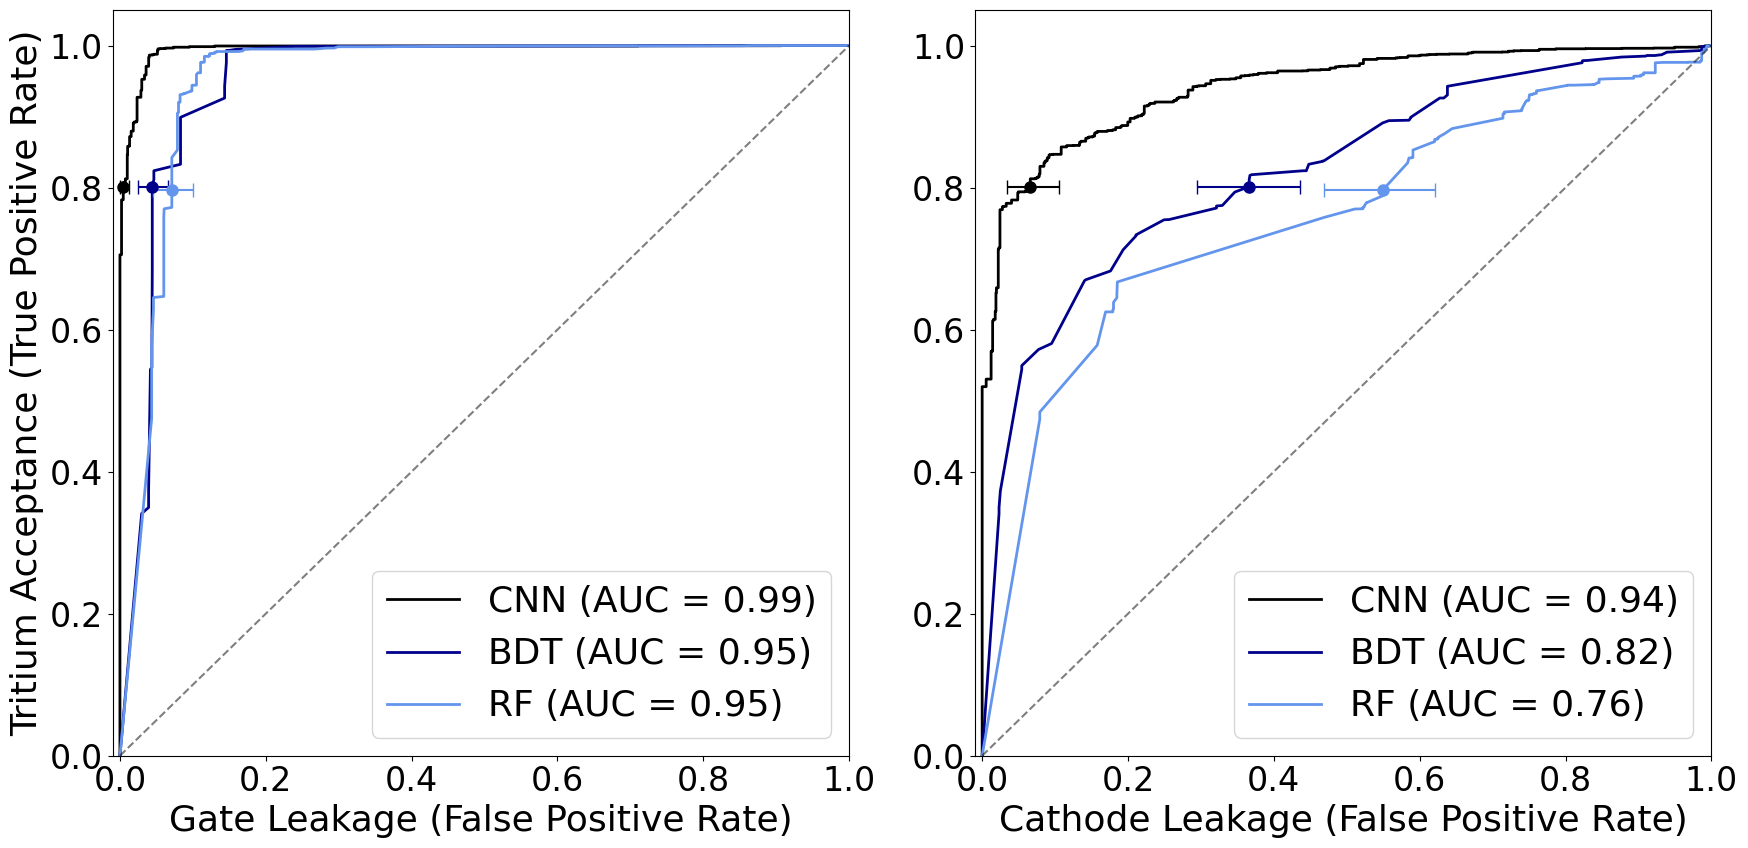

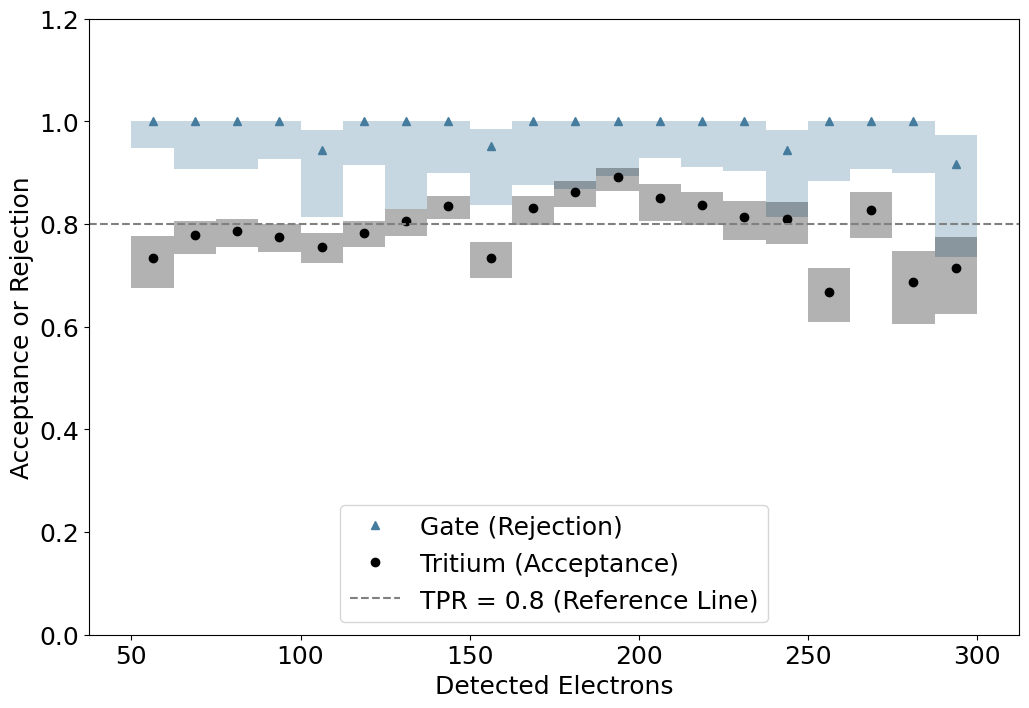

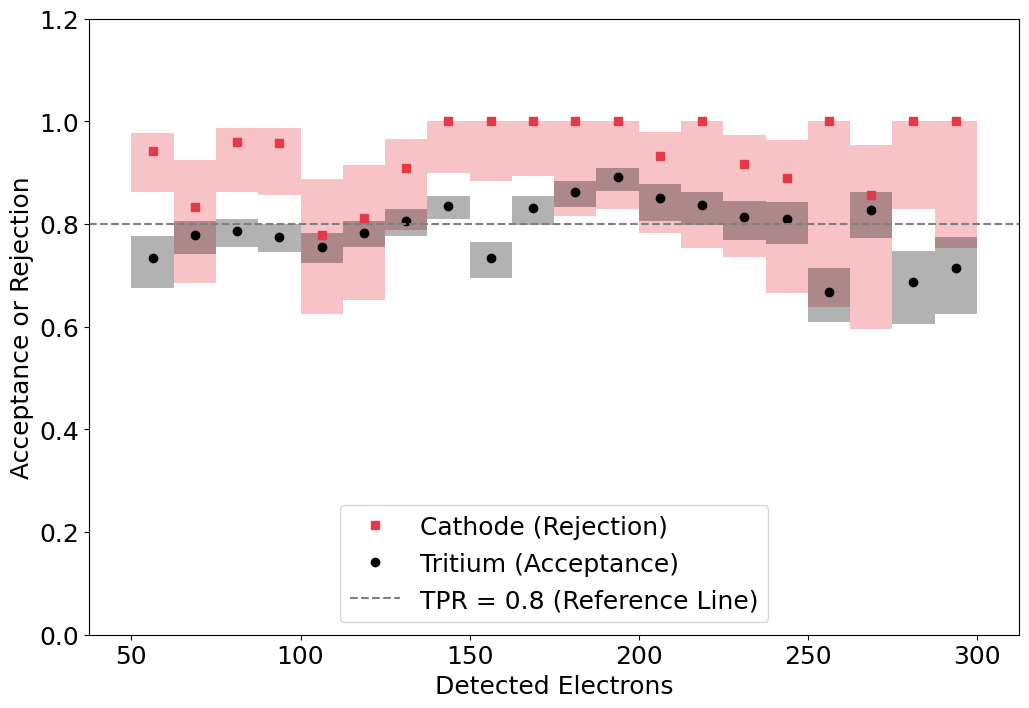

In [3]:
# Set random seeds for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

def load_and_prepare_data(data_path = DATA_path):
    """
    Load and prepare the data for modeling.
    """
    print("Loading data...")
    # Load data
    
    # Create feature set for BDT and RF
    bdt_features = df[['area', 'max_pulse_height', 'r', 'S2_width', 'x', 'y']]
    
    # Split data
    X_bdt_train, X_bdt_test= train_test_split(bdt_features, test_size=0.25, random_state=seed_value)
  
    # Make sure we're using normalized weights
    normalized_weights_train = weights_train
    normalized_weights_test = weights_test
  
    print(f"Data prepared. Training samples: {len(X_train_padded)}, Test samples: {len(X_test_padded)}")
    
    return {
        'X_cnn_train': X_train_padded,
        'X_cnn_test': X_test_padded,
        'X_bdt_train': X_bdt_train,
        'X_bdt_test': X_bdt_test,
        'y_train': y_train,
        'y_test': y_test,
        'weights_train': normalized_weights_train,
        'weights_test': normalized_weights_test,
        'area_test': area_test
    }

def build_and_train_models(data):
    """
    Build and train the CNN, BDT, and RF models.
    CNN trained as before, BDT and RF with reduced performance.
    """
    print("Building and training models...")
    models = {}
    predictions = {}
    
    # Ensure we're using normalized weights
    normalized_weights_train = data['weights_train']  # These should be normalized weights from load_and_prepare_data
    normalized_weights_test = data['weights_test']    # These should be normalized weights from load_and_prepare_data
    
    # 1. CNN Model with exact configuration from provided code
    print("Training CNN model...")
    
    # Setup callbacks for CNN
    early_stopping = EarlyStopping(
        monitor='val_loss',
        min_delta=0.005,
        patience=3,
        verbose=1,
        restore_best_weights=True
    )
    
    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    )
    
    callbacks = [early_stopping, lr_scheduler]
    
    # Define the CNN model with the exact architecture provided
    convoNN = keras.Sequential([
        # First 1D convolution layer
        keras.layers.Conv1D(
            filters=64, 
            kernel_size=100, 
            activation='relu', 
            padding='same', 
            kernel_regularizer=regularizers.l2(0.001), 
            input_shape=(data['X_cnn_train'].shape[1], 1)
        ),
        keras.layers.MaxPooling1D(pool_size=2),
        Dropout(0.2),
        
        # Second 1D convolution layer
        keras.layers.Conv1D(
            filters=154, 
            kernel_size=60, 
            padding='same', 
            activation='relu'
        ),
        keras.layers.MaxPooling1D(pool_size=2),
        # Dropout(0.3),  # Commented out as in original code
        
        # Flatten layer
        keras.layers.Flatten(),
        keras.layers.Dense(96, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        keras.layers.Dense(3, activation='softmax')
    ])
    
    # Compile the model with legacy Adam optimizer
    optimizer = legacy.Adam(learning_rate=5.762e-4)
    convoNN.compile(
        optimizer=optimizer, 
        loss='sparse_categorical_crossentropy', 
        metrics=['accuracy']
    )
    
    # Train the model with callbacks
    history = convoNN.fit(
        data['X_cnn_train'], 
        data['y_train'], 
        sample_weight=normalized_weights_train,
        epochs=15, 
        batch_size=323, 
        validation_split=0.2, 
        callbacks=callbacks, 
        verbose=1  # Set to 1 to show progress
    )
    
    # Get CNN predictions
    predictions['cnn'] = convoNN.predict(data['X_cnn_test'], verbose=0)
    models['cnn'] = convoNN
    
    # Plot training history
    plt.figure(figsize=(12, 8))
    
    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], color='#E63946', linewidth=2.5, label='Train')
    plt.plot(history.history['val_accuracy'], color='#457B9D', linewidth=2.5, label='Validation')
    plt.ylabel('Accuracy', fontsize=18)
    plt.xlabel('Epoch', fontsize=18)
    plt.legend(loc='lower right', fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    
    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], color='#E63946', linewidth=2.5, label='Train')
    plt.plot(history.history['val_loss'], color='#457B9D', linewidth=2.5, label='Validation')
    plt.ylabel('Loss', fontsize=18)
    plt.xlabel('Epoch', fontsize=18)
    if len(history.history['loss']) > 10:
        plt.xlim(0, 10)
    plt.legend(loc='upper right', fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    
    plt.tight_layout()
    plt.savefig('training_validation_metrics.png', dpi=1200)
    plt.show()
    
    # 2. XGBoost (BDT) Model with reduced performance
    print("Training BDT model...")
    # Make sure to use normalized weights
    dtrain = xgb.DMatrix(data['X_bdt_train'], label=data['y_train'], weight=normalized_weights_train)
    dtest = xgb.DMatrix(data['X_bdt_test'], label=data['y_test'], weight=normalized_weights_test)
    
    # Reduced performance parameters
    params = {
        "objective": "multi:softprob",
        "num_class": 3,
        "eval_metric": "mlogloss",
        "eta": 0.01,         # Reduced learning rate
        "max_depth": 2,      # Reduced depth
        "seed": seed_value
    }
    
    bst = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=50,  # Fewer boosting rounds
        verbose_eval=False
    )
    
    # Get BDT predictions
    predictions['bdt'] = bst.predict(dtest)
    models['bdt'] = bst
    
    # 3. Random Forest Model with reduced performance
    print("Training RF model...")
    rf_model = RandomForestClassifier(
        n_estimators=10,     # Fewer trees
        max_depth=3,         # Shallow trees
        min_samples_split=20, # More conservative splitting
        max_features='sqrt', 
        random_state=seed_value
    )
    
    # Make sure to use normalized weights for training
    rf_model.fit(data['X_bdt_train'], data['y_train'], sample_weight=normalized_weights_train)
    
    # Get RF predictions
    predictions['rf'] = rf_model.predict_proba(data['X_bdt_test'])
    models['rf'] = rf_model
    
    print("All models trained.")
    return models, predictions, data['y_test'], normalized_weights_test, data['area_test']

def plot_roc_curves(y_test, cnn_probs, bdt_probs, rf_probs, weights_test=None, area_test=None, event_types=['gate', 'cathode'], save_plots=True):
    """
    Plot ROC curves comparing CNN, BDT, and RF models with stratified bootstrap error bars at TPR=0.8.
    Both ROC curves (gate and cathode) are shown side-by-side in a single figure.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_curve, auc
    from scipy.stats import binomtest
    
    plt.rcParams['font.size'] = 24
    
    models = {
        'CNN': {'probs': cnn_probs, 'color': 'black', 'linestyle': '-', 'linewidth': 2},
        'BDT': {'probs': bdt_probs, 'color': 'darkblue', 'linestyle': '-', 'linewidth': 2},
        'RF': {'probs': rf_probs, 'color': 'cornflowerblue', 'linestyle': '-', 'linewidth': 2}
    }
    
    # Default to uniform weights if none provided
    if weights_test is None:
        print("WARNING: No weights provided to plot_roc_curves! Using uniform weights.")
        weights_test = np.ones(len(y_test))
        
    # Target TPR for error bar
    target_tpr = 0.8
    
    # Number of bootstrap samples
    n_bootstraps = 1000
    
    fig, axs = plt.subplots(1, 2, figsize=(18, 9))
    
    # Plot ROC curves for each event type in the respective subplot
    for idx, event_type in enumerate(event_types):
        # Set up the event-specific data
        if event_type == 'gate':
            event_idx = 1
            xlabel = 'Gate Leakage (False Positive Rate)'
            filename = 'ROC_curves_combined.png'
            color = '#457B9D'  # Blue for Gate
            marker = '^'
        else:  # cathode
            event_idx = 0
            xlabel = 'Cathode Leakage (False Positive Rate)'
            color = '#E63946'  # Red for Cathode
            marker = 's'
        
        # Current subplot
        ax = axs[idx]
        
        # Create binary classification mask (tritium vs the specific event type)
        mask = (y_test == 2) | (y_test == event_idx)
        binary_labels = np.where(y_test[mask] == 2, 1, 0)  # Tritium = 1, Other = 0
        binary_weights = weights_test[mask]
        
        # Split data for stratified bootstrap
        pos_indices = np.where(binary_labels == 1)[0]  # Tritium indices
        neg_indices = np.where(binary_labels == 0)[0]  # Gate/Cathode indices
        
        # Store threshold points for each model
        threshold_points = {}
        
        # Plot each model's ROC curve
        for model_name, model_info in models.items():
            # Get tritium probabilities for binary classification
            tritium_probs = model_info['probs'][mask, 2]
            
            # Calculate ROC curve and AUC with sample weights
            fpr, tpr, thresholds = roc_curve(binary_labels, tritium_probs, sample_weight=binary_weights)
            
            # Apply smoothing for BDT and RF models - use more decision thresholds
            if model_name in ['BDT', 'RF']:
                # Get the min and max probability values
                min_prob = np.min(tritium_probs)
                max_prob = np.max(tritium_probs)
                
                # Generate threshold points for a smoother curve
                # Include a threshold higher than max_prob to ensure we get the (0,0) point
                additional_thresholds = np.concatenate([
                    [max_prob + 0.0001],  # Add a threshold higher than max to get (0,0) point
                    np.linspace(min_prob, max_prob, 2000)
                ])
                
                fpr_smooth = []
                tpr_smooth = []
                
                for threshold in additional_thresholds:
                    pred = (tritium_probs >= threshold).astype(int)
                    
                    # Calculate TPR (weighted)
                    pos_mask = (binary_labels == 1)
                    tp = np.sum(binary_weights[pos_mask & (pred == 1)])
                    fn = np.sum(binary_weights[pos_mask & (pred == 0)])
                    tpr_val = tp / (tp + fn) if (tp + fn) > 0 else 0
                    
                    # Calculate FPR (weighted)
                    neg_mask = (binary_labels == 0)
                    fp = np.sum(binary_weights[neg_mask & (pred == 1)])
                    tn = np.sum(binary_weights[neg_mask & (pred == 0)])
                    fpr_val = fp / (fp + tn) if (fp + tn) > 0 else 0
                    
                    fpr_smooth.append(fpr_val)
                    tpr_smooth.append(tpr_val)
                
                # Sort by increasing FPR
                points = sorted(zip(fpr_smooth, tpr_smooth, additional_thresholds))
                fpr_smooth = [p[0] for p in points]
                tpr_smooth = [p[1] for p in points]
                thresholds = [p[2] for p in points]
                
                # Use the smoothed curves
                fpr, tpr = fpr_smooth, tpr_smooth
            
            roc_auc = auc(fpr, tpr)
            
            # Plot the ROC curve
            ax.plot(
                fpr, tpr, 
                label=f'{model_name} (AUC = {roc_auc:.2f})',
                color=model_info['color'],
                linestyle=model_info['linestyle'],
                linewidth=model_info['linewidth']
            )
            
            # Find point closest to target TPR
            idx_tpr = np.argmin(np.abs(np.array(tpr) - target_tpr))
            threshold_points[model_name] = {
                'coords': (fpr[idx_tpr], tpr[idx_tpr]), 
                'threshold': thresholds[idx_tpr],
                'probs': tritium_probs,
                'color': model_info['color']
            }
            
            # Calculate and add error bars using stratified bootstrap
            fprs_at_threshold = []
            threshold = threshold_points[model_name]['threshold']
            
            # Perform stratified bootstrap
            for _ in range(n_bootstraps):
                # Sample with replacement separately for each class
                pos_bootstrap_indices = np.random.choice(pos_indices, len(pos_indices), replace=True)
                neg_bootstrap_indices = np.random.choice(neg_indices, len(neg_indices), replace=True)
                
                # Combine indices while maintaining class proportions
                bootstrap_indices = np.concatenate([pos_bootstrap_indices, neg_bootstrap_indices])
                
                # Extract bootstrap samples
                y_bootstrap = binary_labels[bootstrap_indices]
                probs_bootstrap = tritium_probs[bootstrap_indices]
                weights_bootstrap = binary_weights[bootstrap_indices]
                
                # Apply fixed threshold from original data
                preds_bootstrap = (probs_bootstrap >= threshold).astype(int)
                
                # Calculate weighted FPR
                neg_mask = (y_bootstrap == 0)
                fp = np.sum(weights_bootstrap[neg_mask & (preds_bootstrap == 1)])
                tn = np.sum(weights_bootstrap[neg_mask & (preds_bootstrap == 0)])
                
                fpr_bootstrap = fp / (fp + tn) if (fp + tn) > 0 else 0
                fprs_at_threshold.append(fpr_bootstrap)
            
            # Calculate 95% confidence interval
            fprs_at_threshold.sort()
            lower_bound = fprs_at_threshold[int(0.025 * n_bootstraps)]
            upper_bound = fprs_at_threshold[int(0.975 * n_bootstraps)]
            
            # Add error bar at target TPR
            coords = threshold_points[model_name]['coords']
            ax.errorbar(
                coords[0], coords[1], 
                xerr=[[coords[0] - lower_bound], [upper_bound - coords[0]]],
                fmt='o', color=model_info['color'], capsize=5, markersize=8
            )
        
        # Add diagonal reference line
        ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)
        
        # Add plot labels and styling
        ax.set_xlabel(xlabel, fontsize=26)
        if idx == 0:
            ax.set_ylabel('Tritium Acceptance (True Positive Rate)', fontsize=26)
        
        # CORRECTION: Add legend to both subplots
        ax.legend(loc='lower right', fontsize=26)
        
        ax.grid(False)
        
        # Set axis limits - show a bit before 0.0 on x-axis
        ax.set_xlim([-0.01, 1.0])
        ax.set_ylim([0.0, 1.05])
        
    # Adjust layout and save the combined figure
    plt.tight_layout()
    
    if save_plots:
        plt.savefig('ROC_curves_combined.png', dpi=1400, bbox_inches='tight')
    
    plt.show()
    
    # Also create individual plots for each model
    if save_plots:
        for model_name, model_info in models.items():
            for event_type in event_types:
                plt.figure(figsize=(12, 8))
                
                # Set up the event-specific data
                if event_type == 'gate':
                    event_idx = 1
                    xlabel = 'Gate Leakage (False Positive Rate)'
                else:  # cathode
                    event_idx = 0
                    xlabel = 'Cathode Leakage (False Positive Rate)'
                
                # Create binary classification mask
                mask = (y_test == 2) | (y_test == event_idx)
                binary_labels = np.where(y_test[mask] == 2, 1, 0)
                binary_weights = weights_test[mask]
                
                # Split data for stratified bootstrap
                pos_indices = np.where(binary_labels == 1)[0]
                neg_indices = np.where(binary_labels == 0)[0]
                
                # Get tritium probabilities for binary classification
                tritium_probs = model_info['probs'][mask, 2]
                
                # Calculate ROC curve and AUC with sample weights
                fpr, tpr, thresholds = roc_curve(binary_labels, tritium_probs, sample_weight=binary_weights)
                
                # Apply smoothing for BDT and RF models
                if model_name in ['BDT', 'RF']:
                    # Get the min and max probability values
                    min_prob = np.min(tritium_probs)
                    max_prob = np.max(tritium_probs)
                    
                    # Generate threshold points for a smoother curve
                    # Include a threshold higher than max_prob to ensure we get the (0,0) point
                    additional_thresholds = np.concatenate([
                        [max_prob + 0.0001],  # Add a threshold higher than max to get (0,0) point
                        np.linspace(min_prob, max_prob, 2000)
                    ])
                    
                    fpr_smooth = []
                    tpr_smooth = []
                    
                    for threshold in additional_thresholds:
                        pred = (tritium_probs >= threshold).astype(int)
                        
                        # Calculate TPR (weighted)
                        pos_mask = (binary_labels == 1)
                        tp = np.sum(binary_weights[pos_mask & (pred == 1)])
                        fn = np.sum(binary_weights[pos_mask & (pred == 0)])
                        tpr_val = tp / (tp + fn) if (tp + fn) > 0 else 0
                        
                        # Calculate FPR (weighted)
                        neg_mask = (binary_labels == 0)
                        fp = np.sum(binary_weights[neg_mask & (pred == 1)])
                        tn = np.sum(binary_weights[neg_mask & (pred == 0)])
                        fpr_val = fp / (fp + tn) if (fp + tn) > 0 else 0
                        
                        fpr_smooth.append(fpr_val)
                        tpr_smooth.append(tpr_val)
                    
                    # Sort by increasing FPR
                    points = sorted(zip(fpr_smooth, tpr_smooth, additional_thresholds))
                    fpr_smooth = [p[0] for p in points]
                    tpr_smooth = [p[1] for p in points]
                    thresholds = [p[2] for p in points]
                    
                    # Use the smoothed curves
                    fpr, tpr = fpr_smooth, tpr_smooth
                
                roc_auc = auc(fpr, tpr)
                
                # Plot the ROC curve
                plt.plot(
                    fpr, tpr, 
                    label=f'{model_name} (AUC = {roc_auc:.2f})', 
                    color=model_info['color'],
                    linestyle=model_info['linestyle'],
                    linewidth=model_info['linewidth']
                )
                
                # Find point closest to target TPR
                idx = np.argmin(np.abs(np.array(tpr) - target_tpr))
                coords = (fpr[idx], tpr[idx])
                threshold = thresholds[idx]
                
                # Calculate error bars using same bootstrap approach
                fprs_at_threshold = []
                for _ in range(n_bootstraps):
                    # Sample with replacement separately for each class
                    pos_bootstrap_indices = np.random.choice(pos_indices, len(pos_indices), replace=True)
                    neg_bootstrap_indices = np.random.choice(neg_indices, len(neg_indices), replace=True)
                    
                    # Combine indices while maintaining class proportions
                    bootstrap_indices = np.concatenate([pos_bootstrap_indices, neg_bootstrap_indices])
                    
                    # Extract bootstrap samples
                    y_bootstrap = binary_labels[bootstrap_indices]
                    probs_bootstrap = tritium_probs[bootstrap_indices]
                    weights_bootstrap = binary_weights[bootstrap_indices]
                    
                    # Apply fixed threshold from original data
                    preds_bootstrap = (probs_bootstrap >= threshold).astype(int)
                    
                    # Calculate weighted FPR
                    neg_mask = (y_bootstrap == 0)
                    fp = np.sum(weights_bootstrap[neg_mask & (preds_bootstrap == 1)])
                    tn = np.sum(weights_bootstrap[neg_mask & (preds_bootstrap == 0)])
                    
                    fpr_bootstrap = fp / (fp + tn) if (fp + tn) > 0 else 0
                    fprs_at_threshold.append(fpr_bootstrap)
                
                # Calculate 95% confidence interval
                fprs_at_threshold.sort()
                lower_bound = fprs_at_threshold[int(0.025 * n_bootstraps)]
                upper_bound = fprs_at_threshold[int(0.975 * n_bootstraps)]
                
                # Add error bar at target TPR
                plt.errorbar(
                    coords[0], coords[1], 
                    xerr=[[coords[0] - lower_bound], [upper_bound - coords[0]]],
                    fmt='o', color=model_info['color'], capsize=5, markersize=8
                )
                
                # Add diagonal reference line
                plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
                
                # Add plot labels and styling
                plt.xlabel(xlabel, fontsize=18)
                plt.ylabel('Tritium Acceptance (True Positive Rate)', fontsize=26)
                # Title removed as requested
                plt.legend(loc='lower right', fontsize=26)
                plt.grid(False)
                
                # Set axis limits - show a bit before 0.0 on x-axis
                plt.xlim([-0.01, 1.0])
                plt.ylim([0.0, 1.05])
                
                # Save the individual plot
                plt.savefig(f'ROC_curve_{model_name}_{event_type}.png', dpi=1500, bbox_inches='tight')
                plt.close()
    
    # Plot area-dependent performance if area_test is provided
    if area_test is not None:
        plot_area_dependent_performance(y_test, cnn_probs, bdt_probs, rf_probs, area_test, weights_test, event_types, save_plots)

def plot_area_dependent_performance(y_test, cnn_probs, bdt_probs, rf_probs, area_test, weights_test, event_types, save_plots=True):
    """
    Plot area-dependent performance for different models.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import binomtest
    
    # Use only CNN model for area-dependent analysis
    for event_type in event_types:
        # Set up the event-specific data
        if event_type == 'gate':
            event_idx = 1
            filename = 'ROC_area_dependence_gate.png'
            color = '#457B9D'  # Blue for Gate
            marker = '^'
            label = 'Gate (Rejection)'
        else:  # cathode
            event_idx = 0
            filename = 'ROC_area_dependence_cathode.png'
            color = '#E63946'  # Red for Cathode
            marker = 's'
            label = 'Cathode (Rejection)'
        
        # Number of bins for area
        num_bins = 20
        bin_edges = np.linspace(50, 300, num_bins + 1)
        
        # Calculate a threshold that gives 80% tritium acceptance
        tritium_mask = y_test == 2
        tritium_probs = cnn_probs[tritium_mask, 2]
        threshold = np.percentile(tritium_probs, 20)  # 20th percentile gives 80% acceptance
        
        # Initialize arrays for storing results
        tritium_acceptance = []
        event_rejection = []
        tritium_error = []
        event_error = []
        
        # Loop through each bin
        for i in range(len(bin_edges) - 1):
            lower, upper = bin_edges[i], bin_edges[i+1]
            bin_center = (lower + upper) / 2
            bin_width = upper - lower
            
            # Filter data points within the current bin
            bin_mask = (area_test >= lower) & (area_test < upper)
            
            # Skip bins with no data
            if not np.any(bin_mask):
                continue
            
            # Get tritium and event data for this bin
            tritium_bin_mask = bin_mask & (y_test == 2)
            event_bin_mask = bin_mask & (y_test == event_idx)
            
            # Calculate tritium acceptance
            tritium_bin_probs = cnn_probs[tritium_bin_mask, 2]
            if len(tritium_bin_probs) > 0:
                # Count tritium points above threshold
                accepted_tritium = np.sum(tritium_bin_probs >= threshold)
                total_tritium = len(tritium_bin_probs)
                
                # Calculate acceptance rate
                acceptance_rate = accepted_tritium / total_tritium
                tritium_acceptance.append((bin_center, acceptance_rate))
                
                # Calculate confidence intervals using binomial test
                ci = binomtest(accepted_tritium, total_tritium).proportion_ci(confidence_level=0.95)
                lower_error = acceptance_rate - ci.low
                upper_error = ci.high - acceptance_rate
                tritium_error.append((lower_error, upper_error))
            else:
                # No tritium events in this bin
                tritium_acceptance.append((bin_center, 0))
                tritium_error.append((0, 0))
            
            # Calculate event rejection
            event_bin_probs = cnn_probs[event_bin_mask, 2]
            if len(event_bin_probs) > 0:
                # Count event points below threshold (rejected)
                rejected_events = np.sum(event_bin_probs < threshold)
                total_events = len(event_bin_probs)
                
                # Calculate rejection rate
                rejection_rate = rejected_events / total_events
                event_rejection.append((bin_center, rejection_rate))
                
                # Calculate confidence intervals
                ci = binomtest(rejected_events, total_events).proportion_ci(confidence_level=0.95)
                lower_error = rejection_rate - ci.low
                upper_error = ci.high - rejection_rate
                event_error.append((lower_error, upper_error))
            else:
                # No event data in this bin
                event_rejection.append((bin_center, 0))
                event_error.append((0, 0))
        
        # Plot the results
        if len(tritium_acceptance) > 0 and len(event_rejection) > 0:
            # Extract coordinates for plotting
            tritium_x, tritium_y = zip(*tritium_acceptance)
            event_x, event_y = zip(*event_rejection)
            
            # Create a new figure
            plt.figure(figsize=(12, 8))
            
            # Plot event rejection with filled error bars
            for x, y, (lower_error, upper_error) in zip(event_x, event_y, event_error):
                lower_bound = max(0, y - lower_error * 0.6)  # Scale error slightly for better visibility
                upper_bound = min(1, y + upper_error * 0.7)
                
                plt.plot(x, y, marker, color=color, label=label if x == event_x[0] else "")
                plt.fill_between([x - bin_width/2, x + bin_width/2], 
                                lower_bound, upper_bound, 
                                color=color, alpha=0.3, linewidth=0)
            
            # Plot tritium acceptance with filled error bars
            for x, y, (lower_error, upper_error) in zip(tritium_x, tritium_y, tritium_error):
                lower_bound = max(0, y - lower_error * 0.3)
                upper_bound = min(1, y + upper_error * 0.3)
                
                plt.plot(x, y, 'o', color='black', 
                         label='Tritium (Acceptance)' if x == tritium_x[0] else "")
                plt.fill_between([x - bin_width/2, x + bin_width/2], 
                                lower_bound, upper_bound, 
                                color='black', alpha=0.3, linewidth=0)
            
            # Add reference line
            plt.axhline(y=0.8, color='gray', linestyle='--', 
                       label='TPR = 0.8 (Reference Line)')
            
            # Add labels and styling
            plt.xlabel("Detected Electrons", fontsize=18)
            plt.ylabel("Acceptance or Rejection", fontsize=18)
            plt.legend(loc='lower center', fontsize=18)
            plt.xticks(fontsize=18)
            plt.yticks(fontsize=18)
            plt.ylim(0, 1.2)
            
            # Title removed as requested
            
            # Save if requested
            if save_plots:
                plt.savefig(filename, dpi=1500, bbox_inches='tight')
            
            plt.show()

def main(data_path='padded_waveforms.parquet'):
    """
    Main function to run the full pipeline.
    """
    # Load and prepare data
    data = load_and_prepare_data(data_path)
    
    # Build and train models
    models, predictions, y_test, normalized_weights_test, area_test = build_and_train_models(data)
    
    # Plot ROC curves with proper weighting and stratified bootstrap error bars
    plot_roc_curves(
        y_test,
        predictions['cnn'],
        predictions['bdt'],
        predictions['rf'],
        weights_test=normalized_weights_test,  # Using normalized weights
        area_test=area_test,
        event_types=['gate', 'cathode'],
        save_plots=True
    )

if __name__ == "__main__":
    # Call main function with correct data path
    main()